In [105]:
import pandas as pd
import pandas_datareader as web
import numpy as np
import talib as tal
import ta
import hvplot.pandas
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [106]:
#Select stocks
tickers = ['AAPL', 'F', 'BAC']

In [107]:
#Select period - pre-GFC and post-GFC
start = '2007, 1, 1'
end = '2011, 1, 1'

In [108]:
stocks = []
for ticker in tickers:
    stock = web.get_data_yahoo(ticker, start=start, end=end)['Adj Close'].reset_index()
    stock = stock.set_index('Date')
    stocks.append(stock)

In [109]:
#SMA
def sma(df):
    df['MA20'] = df['Adj Close'].rolling(20).mean()
    df['MA50'] = df['Adj Close'].rolling(50).mean()

    df = df.dropna()
    
    buy = []
    sell = []

    for i in range(len(df)):       
        if df.MA20.iloc[i] > df.MA50.iloc[i] and df.MA20.iloc[i-1] < df.MA50.iloc[i-1]:
            buy.append(i)
        elif df.MA20.iloc[i] < df.MA50.iloc[i] and df.MA20.iloc[i-1] > df.MA50.iloc[i-1]:
            sell.append(i)
    
    return buy, sell

In [110]:
#MACD
def macd(df):
    stock['MACD'], stock['MACD signal'], macdhist = tal.MACD(stock['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)

    buy = []
    sell = []

    for i in range(len(stock)):
        if (stock['MACD'].iloc[i] > stock['MACD signal'].iloc[i]) & (stock['MACD'].iloc[i-1] < stock['MACD signal'].iloc[i-1]):
            buy.append(i)
        elif (stock['MACD'].iloc[i] < stock['MACD signal'].iloc[i]) & (stock['MACD'].iloc[i-1] > stock['MACD signal'].iloc[i-1]):
            sell.append(i)
    
    return buy, sell

In [111]:
#RSI
def rsi(df):
    df['SMA200'] = ta.trend.sma_indicator(df['Adj Close'], window=200)
    df['RSI'] = ta.momentum.rsi(df['Adj Close'], window=10)
    df['Signal'] = np.where((df['Adj Close'] > df['SMA200']) & (df.RSI < 30), True, False)

    buy = []
    sell = []

    for i in range(len(df)):
        if df.Signal.iloc[i]:
            buy.append(i + 1)
            for j in range (1,11):
                if df['RSI'].iloc[i + j] > 40:
                    sell.append(i + j + 1)
                    break
                
                elif j == 10:
                    sell.append(i + j + 1)
    return buy, sell

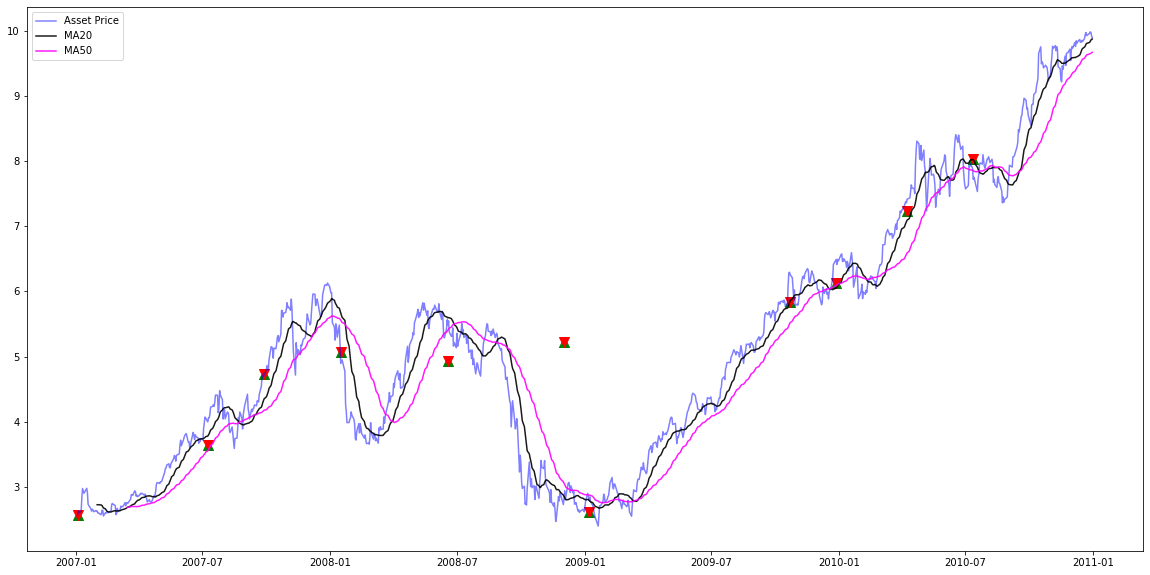

<Figure size 432x288 with 0 Axes>

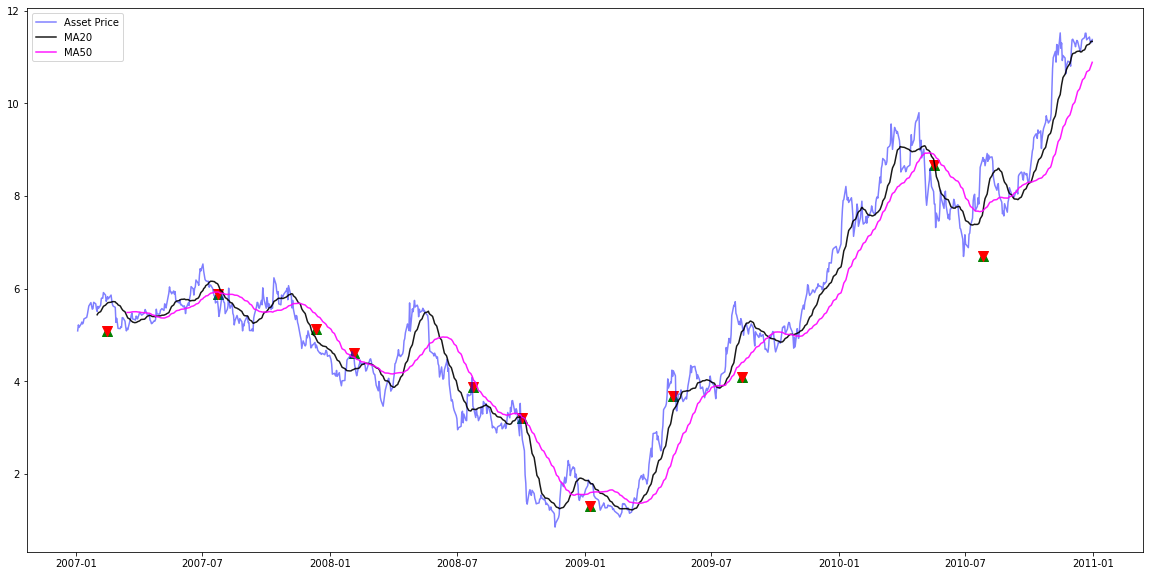

<Figure size 432x288 with 0 Axes>

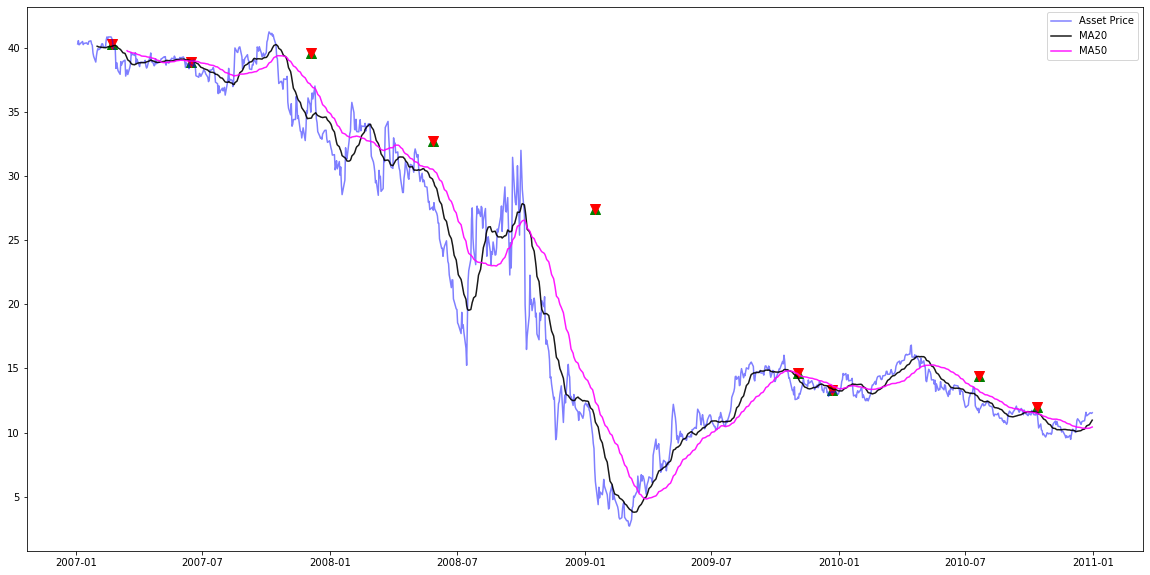

<Figure size 432x288 with 0 Axes>

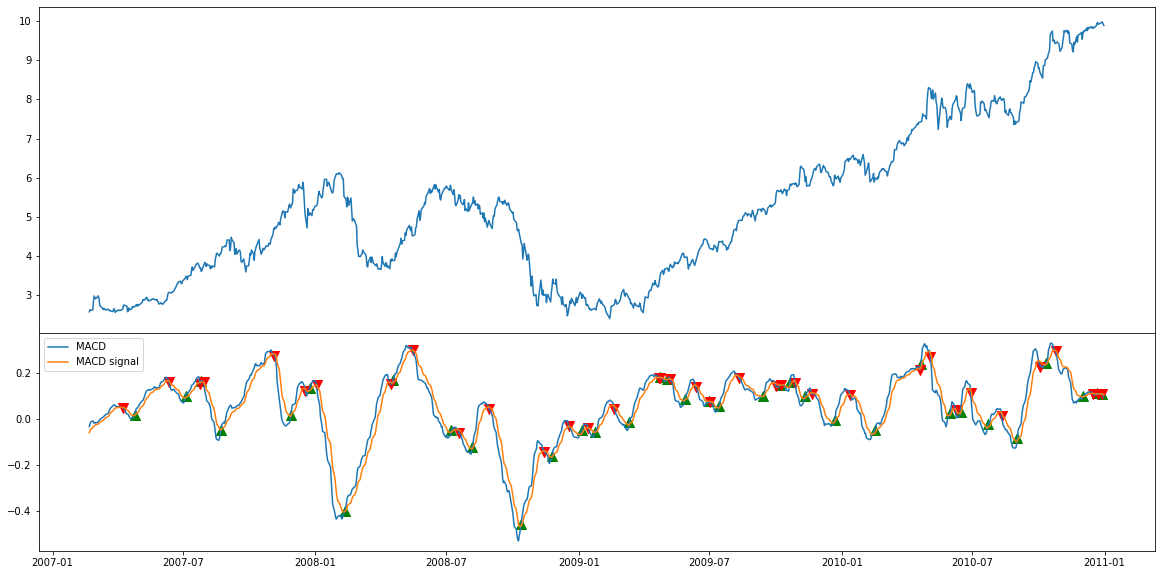

<Figure size 432x288 with 0 Axes>

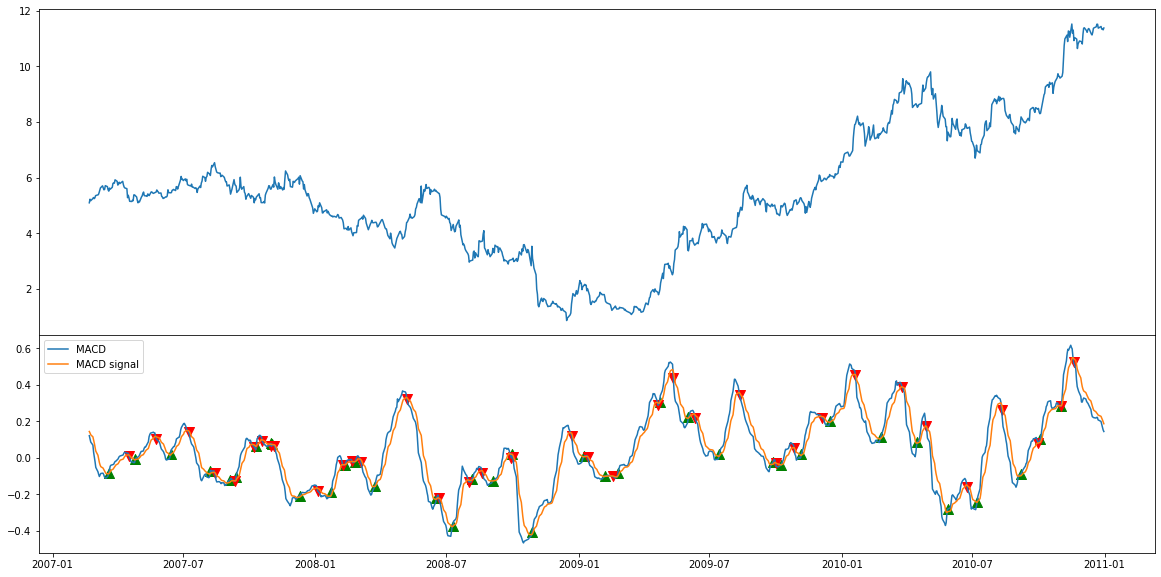

<Figure size 432x288 with 0 Axes>

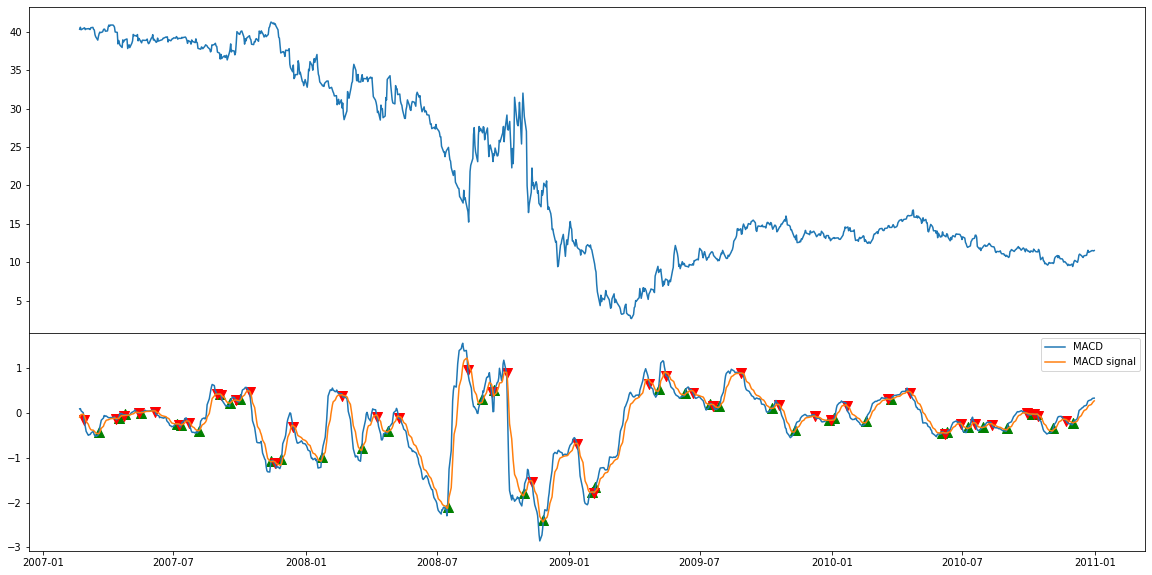

<Figure size 432x288 with 0 Axes>

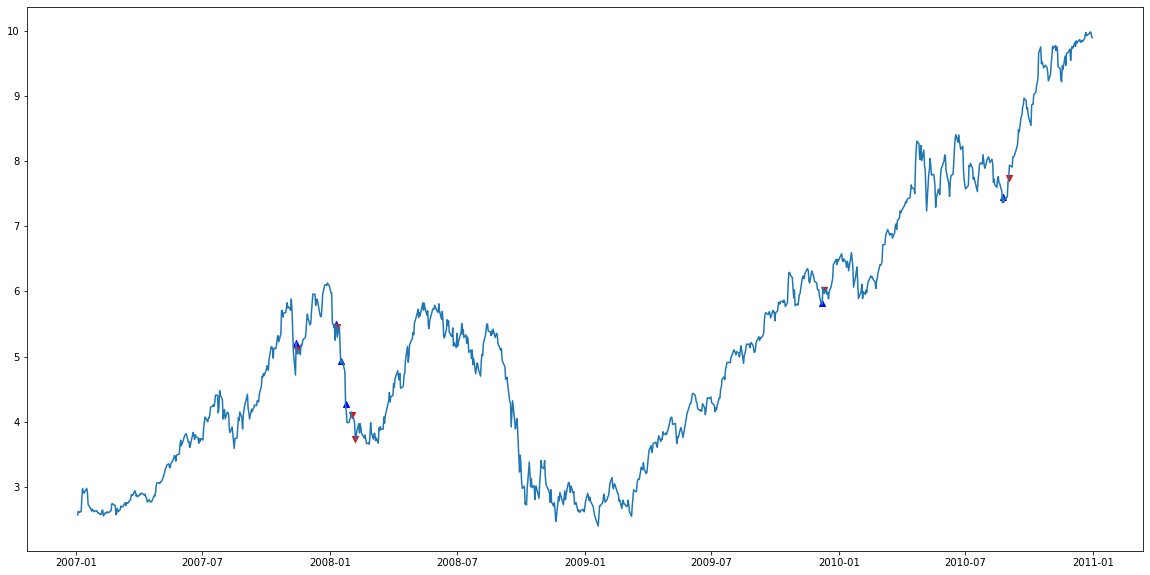

<Figure size 432x288 with 0 Axes>

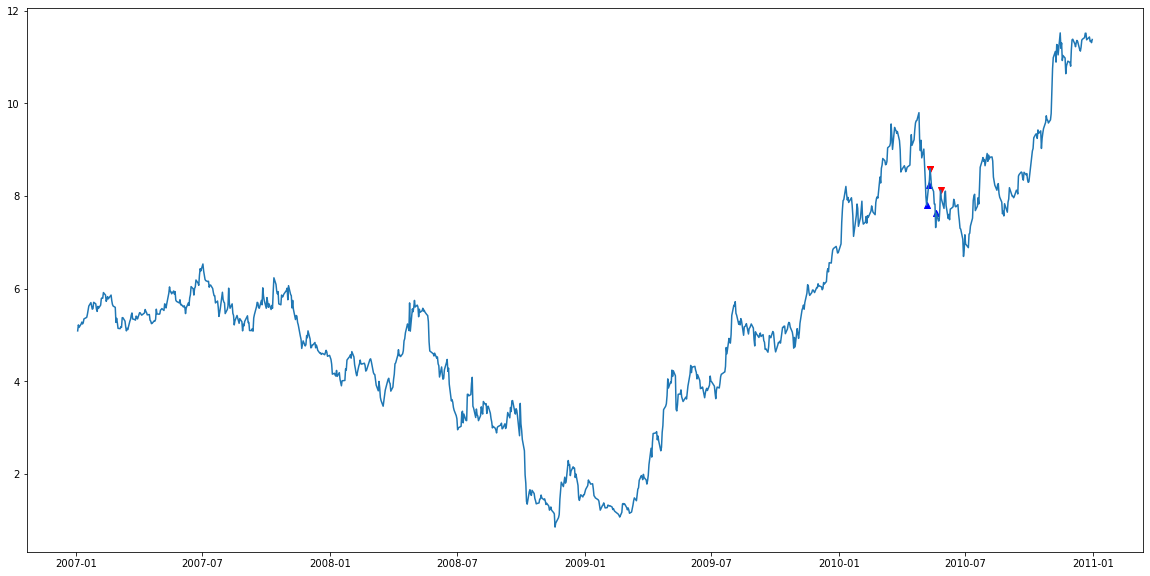

<Figure size 432x288 with 0 Axes>

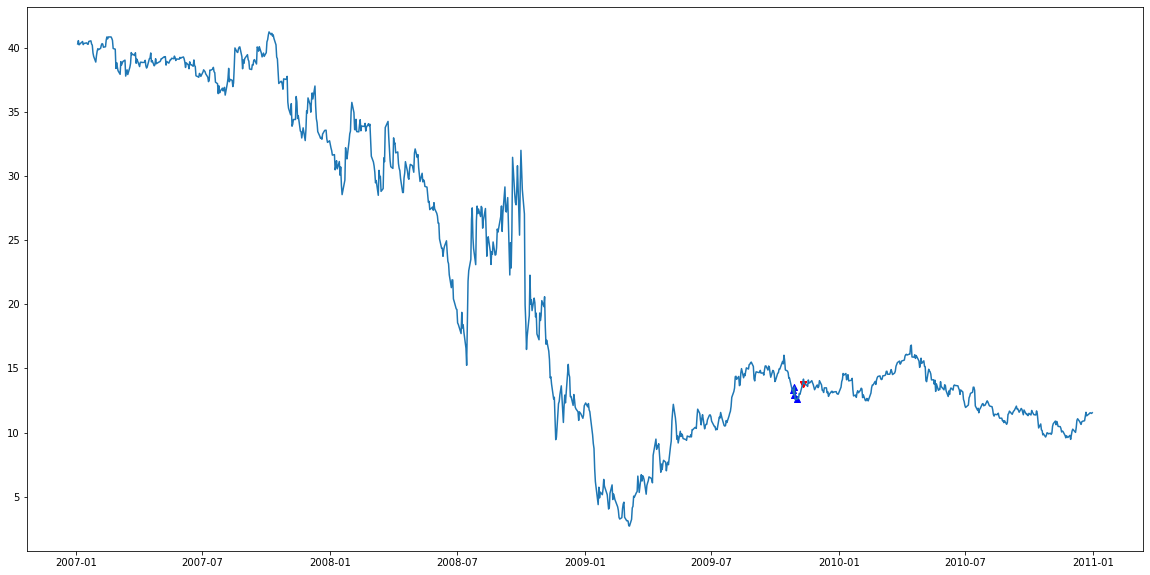

<Figure size 432x288 with 0 Axes>

In [112]:
#Price move charts with buy/sell signals

#SMA price chart
for stock in stocks:
    buy, sell = sma(stock)
    plt.figure(figsize=(20,10))
    plt.plot(stock['Adj Close'], label= 'Asset Price', c='blue', alpha=0.5)
    plt.plot(stock['MA20'], label='MA20', c='black', alpha=0.9)
    plt.plot(stock['MA50'], label='MA50', c='magenta', alpha=0.9)
    plt.scatter(stock.iloc[buy].index,stock.iloc[sell]['Adj Close'], marker='^', c='green', s=100)
    plt.scatter(stock.iloc[buy].index,stock.iloc[sell]['Adj Close'], marker='v', c='red', s=100)
    plt.legend()
    plt.show()
    plt.clf()

#MACD price chart
for stock in stocks:
    buy, sell = macd(stock)
    fig = plt.figure(figsize=(20, 10))
    spec = gridspec.GridSpec(ncols=1, nrows=2,
                         height_ratios=[1.5, 1])
    ax0 = fig.add_subplot(spec[0])
    ax0.plot(stock['Adj Close'])
    ax1 = fig.add_subplot(spec[1])
    ax1.plot(stock[['MACD', 'MACD signal']])
    ax1.scatter(stock.iloc[buy].index, stock.iloc[buy]['MACD'], marker='^', c='green', s=100)
    ax1.scatter(stock.iloc[sell].index, stock.iloc[sell]['MACD'], marker='v', c='red', s=100)
    ax1.legend(['MACD', 'MACD signal'])
    plt.subplots_adjust(hspace=0)
    plt.show()
    plt.clf()

#RSI price chart
for stock in stocks:
    buy, sell = rsi(stock)
    plt.figure(figsize=(20,10))
    plt.scatter(stock.iloc[buy].index, 
            stock.iloc[buy]['Adj Close'], 
            marker='^', 
            c='b')

    plt.scatter(stock.iloc[sell].index, 
            stock.iloc[sell]['Adj Close'], 
            marker='v', 
            c='r')

    plt.plot(stock['Adj Close'])
    plt.show()
    plt.clf()

In [113]:
#Absonute returns & win rates

returns = []
wins = []

for stock in stocks:
    
    sma_buy, sma_sell = sma(stock)
    sma_ret = (stock.iloc[sma_sell]['Adj Close'].values - stock.iloc[sma_buy]['Adj Close'].values) / stock.iloc[sma_buy]['Adj Close'].values
    sma_cum_return = (pd.Series(sma_ret) + 1).cumprod().iloc[-1] - 1
    sma_wins = [i for i in sma_ret if i > 0]
    sma_win_rate = len(sma_wins) / len(sma_ret)
    
    macd_buy, macd_sell = macd(stock)
    if len(macd_buy) > len(macd_sell):
        macd_buy = np.delete(macd_buy, 0)    
    elif len(macd_buy) < len(macd_sell):
        macd_sell = np.delete(macd_sell, 0)
    macd_ret = (stock.iloc[macd_sell]['Adj Close'].values - stock.iloc[macd_buy]['Adj Close'].values) / stock.iloc[macd_buy]['Adj Close'].values
    macd_cum_return = (pd.Series(macd_ret) + 1).cumprod().iloc[-1] - 1
    macd_ret = (stock.iloc[macd_sell]['Adj Close'].values - stock.iloc[macd_buy]['Adj Close'].values) / stock.iloc[macd_buy]['Adj Close'].values
    macd_cum_return = (pd.Series(macd_ret) + 1).cumprod().iloc[-1] - 1
    macd_wins = [i for i in macd_ret if i > 0]
    macd_win_rate = len(macd_wins) / len(macd_ret)
    
    rsi_buy, rsi_sell = rsi(stock)
    rsi_ret = (stock.iloc[rsi_sell]['Adj Close'].values - stock.iloc[rsi_buy]['Adj Close'].values) / stock.iloc[rsi_buy]['Adj Close'].values
    rsi_cum_return = (pd.Series(rsi_ret) + 1).cumprod().iloc[-1] - 1
    rsi_wins = [i for i in rsi_ret if i > 0]
    rsi_win_rate = len(rsi_wins) / len(rsi_ret)
    
    buy_hold = (stock['Adj Close'].pct_change() + 1).cumprod().iloc[-1] - 1
    
    cum_rets = pd.DataFrame([sma_cum_return, macd_cum_return, rsi_cum_return, buy_hold], index=['SMA', 'MACD', 'RSI', 'Buy & Hold'])
    returns.append(cum_rets)
    
    win_rates = pd.DataFrame([sma_win_rate, macd_win_rate, rsi_win_rate], index=['SMA', 'MACD', 'RSI'])
    wins.append(win_rates)

In [122]:
returns[0].hvplot.bar(title='Apple Return')

:Bars   [index]   (0)

In [115]:
returns[1].hvplot.bar(title='Ford Return')

:Bars   [index]   (0)

In [116]:
returns[2].hvplot.bar(title='Bank of America Return')

:Bars   [index]   (0)

In [117]:
wins[0].hvplot.bar(title='Apple Win Rate')

:Bars   [index]   (0)

In [118]:
wins[1].hvplot.bar(title='Ford Win Rate')

:Bars   [index]   (0)

In [119]:
wins[2].hvplot.bar(title='Bank of America Win Rate')

:Bars   [index]   (0)